This analysis is on the wonderful [MovieLens 10M dataset](http://files.grouplens.org/datasets/movielens/ml-10m-README.html), which contains around 10 million ratings of 10,681 movies by 71,567 users.

I used [this list](http://www.timeout.com/london/film/the-50-best-christmas-movies) of the 50 best Christmas movies.

In [1]:
import lxml.html
from lxml.cssselect import CSSSelector

In [2]:
import requests

In [3]:
def get_title(node):
    h3_elem = node.cssselect('div.feature-item__text h3')[0]
    anchor_elem = h3_elem.cssselect('a')
    if len(anchor_elem) == 0:
        return h3_elem.text_content()
    else:
        return anchor_elem[0].text_content()

In [4]:
r = requests.get("http://www.timeout.com/london/film/the-50-best-christmas-movies")

In [5]:
tree = lxml.html.fromstring(r.text)

In [6]:
items_selector = CSSSelector('article.feature-item')
all_items = items_selector(tree)

h3_titles = [get_title(item) for item in all_items[0:50]]

In [8]:
titles = [t.replace('\n', '').strip() for t in h3_titles]

In [9]:
titles = [t.encode('utf8').replace('\xe2\x80\x99', '\'') for t in titles]

In [10]:
import re
for i, t in enumerate(titles):
    if re.match("^The", t):
        t = re.sub(r'^The ', '', t)
        titles[i] = t[:-7] + ", The" + t[-7:]

In [11]:
for i, t in enumerate(titles):
    if re.match("^A", t):
        t = re.sub(r'^A ', '', t)
        titles[i] = t[:-7] + ", A" + t[-7:]

In [12]:
titles[5] = titles[5].replace('Joyeux No\xc3\xabl (2005)', 
                              'Joyeux')

In [14]:
f = open("christmas_movies.txt", "w")
f.write("\n".join(map(lambda x: str(x), titles)))
f.close()

In [ ]:
DROP TABLE IF EXISTS ratingsdata;
CREATE TABLE ratingsdata ( 
   userid INT, 
   itemid INT, 
   rating INT, 
   timestamp INT, 
   PRIMARY KEY (userid, itemid)); 

In [ ]:
DROP TABLE IF EXISTS movies;
CREATE TABLE movies ( 
   itemid INT PRIMARY KEY, 
   title TEXT, 
   genres TEXT,
   action INT DEFAULT 0,
   adventure INT DEFAULT 0,
   animation INT DEFAULT 0,
   childrens INT DEFAULT 0,
   comedy INT DEFAULT 0,
   crime INT DEFAULT 0,
   documentary INT DEFAULT 0,
   drama INT DEFAULT 0,
   fantasy INT DEFAULT 0,
   noir INT DEFAULT 0,
   horror INT DEFAULT 0,
   musical INT DEFAULT 0,
   mystery INT DEFAULT 0,
   romance INT DEFAULT 0,
   scifi INT DEFAULT 0,
   thriller INT DEFAULT 0,
   war INT DEFAULT 0,
   western INT DEFAULT 0);

In [ ]:
DROP TABLE IF EXISTS christmas;
CREATE TABLE christmas (
	name TEXT);

In [ ]:
CREATE INDEX usersdata_index ON ratingsdata (userid); 
CREATE INDEX itemsdata_index ON ratingsdata (itemid);

In [ ]:
LOAD DATA LOCAL INFILE '/Users/jburchell/Documents/MovieLens/ml-10M100K/ratings.dat' 
	INTO TABLE ratingsdata 
	FIELDS TERMINATED BY '::';
    
LOAD DATA LOCAL INFILE '/Users/jburchell/Documents/MovieLens/ml-10M100K/movies.dat' 
	INTO TABLE movies 
	FIELDS TERMINATED BY '::';
    
LOAD DATA LOCAL INFILE '/Users/jburchell/Documents/MovieLens/christmas_movies.txt' 
	INTO TABLE christmas;

In [ ]:
SELECT COUNT(name) 
FROM (
   SELECT * 
   FROM christmas 
   INNER JOIN movies
   ON UPPER(movies.title)
      LIKE CONCAT('%', UPPER(christmas.name), '%')
) AS counts;

In [60]:
from pandas import Series, DataFrame
import pandas as pd
import mysql.connector

cnx = mysql.connector.connect(user='Jodie', password='j0d1e',
                              host='192.168.99.100',
                              database='MovieLens', 
                              port = 32769)

In [62]:
# Fix up title for Joyeux Noël

query = ("""\
UPDATE movies
SET title = REPLACE(title,'Merry Christmas (Joyeux NoÃ«l) (2005)',
                   'Merry Christmas (Joyeux Noël) (2005)');
""")

cursor = cnx.cursor() 
cursor.execute(query)

In [63]:
query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid)
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
df1 = DataFrame(cursor.fetchall(), 
               columns = ['Title', 'AverageRating'])

In [64]:
df1

,Title,AverageRating
0,"Christmas Story, A (1983)",4.1761
1,It's a Wonderful Life (1946),4.1568
2,Brazil (1985),4.1246
3,In Bruges (2008),4.1119
4,Kiss Kiss Bang Bang (2005),4.1001
5,Merry Christmas (Joyeux Noël) (2005),4.0465
6,Die Hard (1988),4.0295
7,Love Actually (2003),3.9936
8,"Charlie Brown Christmas, A (1965)",3.9250
9,"Christmas Carol, A (1938)",3.9021


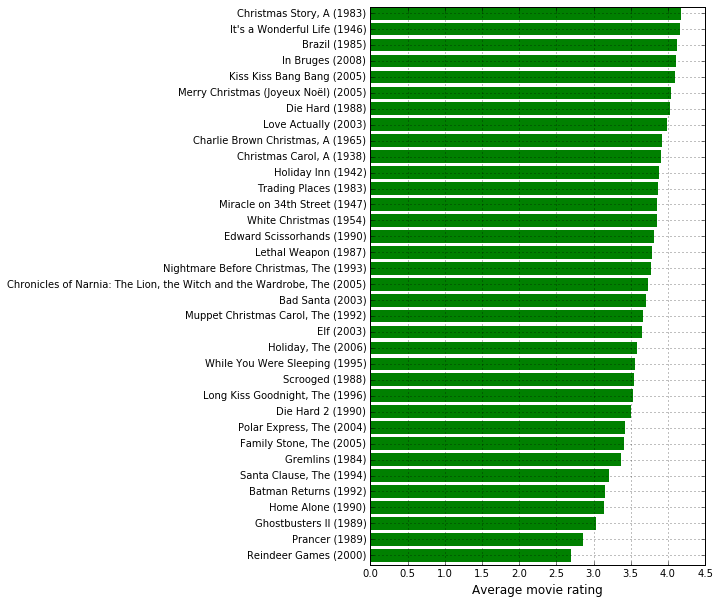

In [100]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(len(df1))

fig = plt.figure(figsize = (720/120, 1200/120), dpi = 120)
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, df1['AverageRating'], color = "g",
                   edgecolor='none')
plt.yticks(x + 0.4, df1['Title'])
plt.gca().invert_yaxis()
plt.xlabel('Average movie rating', fontsize = 12)
plt.grid(True)

In [65]:
# Average ratings for Christmas movies Jan-Nov

query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr 
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid) 
   AND NOT MONTH(FROM_UNIXTIME(ratingsdata.timestamp)) = 12
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
NotDec = DataFrame(cursor.fetchall(), 
                   columns = ['Title', 'AverageRating'])

In [66]:
# Average ratings for Christmas movies in December

query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr 
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid) 
   AND MONTH(FROM_UNIXTIME(ratingsdata.timestamp)) = 12
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
Dec = DataFrame(cursor.fetchall(), 
                columns = ['Title', 'AverageRating'])

In [101]:
df2 = pd.merge(NotDec, Dec, left_on='Title', right_on='Title', how='outer')
df2['diff'] = df2['AverageRating_y'] - df2['AverageRating_x']

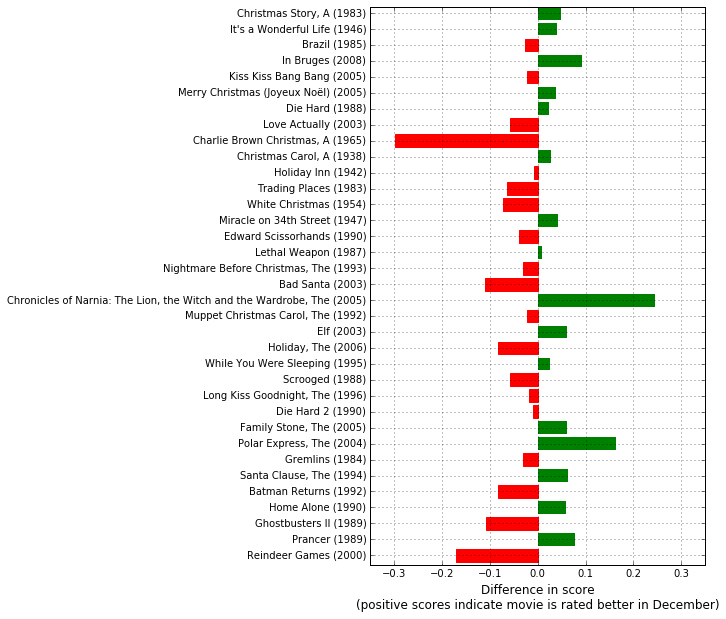

In [98]:
x = np.arange(len(df2))
idx = df2[df2['diff'] <= 0].index.tolist()

fig = plt.figure(figsize = (720/120, 1200/120), dpi = 120)
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, df2['diff'], color = "g",
                   edgecolor='none')
plt.yticks(x + 0.4, df2['Title'])
plt.gca().invert_yaxis()
for i in idx:
    barlist[i].set_color('r')
plt.xlabel('Difference in score\n(positive scores indicate movie is rated better in December)', fontsize = 12)
plt.xlim((-0.35, 0.35))
plt.grid(True)

In [71]:
## Average ratings by movie and year

query = ("""\
SELECT movies.title AS Title, 
    YEAR(FROM_UNIXTIME(ratingsdata.timestamp)) as Year,
	AVG(ratingsdata.rating) AS AverageRating
FROM movies
INNER JOIN ratingsdata
ON movies.itemid = ratingsdata.itemid
WHERE movies.itemid IN (
	SELECT christmasids.itemid
	FROM movies
	INNER JOIN christmasids
		ON movies.itemid = christmasids.itemid)
GROUP BY movies.title, Year;
""")

cursor = cnx.cursor() 
cursor.execute(query)
df3 = DataFrame(cursor.fetchall(), 
               columns = ['Title', 'Year', 
                          'AverageRating'])

In [180]:
df2

,Title,AverageRating_x,AverageRating_y,diff
0,"Christmas Story, A (1983)",4.1686,4.2167,0.0481
1,It's a Wonderful Life (1946),4.1519,4.1914,0.0395
2,Brazil (1985),4.1278,4.1022,-0.0256
3,In Bruges (2008),4.1046,4.1964,0.0918
4,Kiss Kiss Bang Bang (2005),4.1021,4.0807,-0.0214
5,Merry Christmas (Joyeux Noël) (2005),4.0408,4.0800,0.0392
6,Die Hard (1988),4.0270,4.0498,0.0228
7,Love Actually (2003),4.0000,3.9422,-0.0578
8,"Charlie Brown Christmas, A (1965)",3.9653,3.6667,-0.2986
9,"Christmas Carol, A (1938)",3.8978,3.9250,0.0272


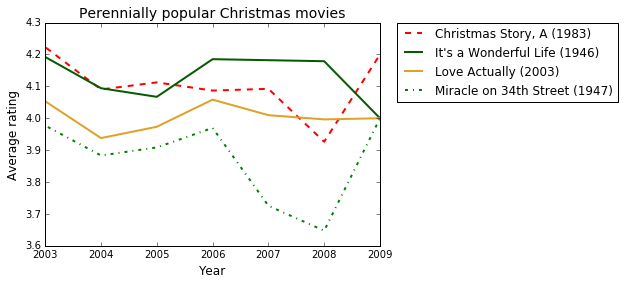

In [302]:
# Plot the consistently highly rated Christmas movies

fig = plt.figure(figsize = (720/120, 500/120), dpi = 120)                                                  
ax = fig.add_subplot(1,1,1)

# Add lines
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][0]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][0]],
         color='#FF0000', linestyle='dashed', linewidth=2.0,
         label = df2['Title'][0])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][1]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][1]],
         color='#065A00', linewidth=2.0, 
         label = df2['Title'][1])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][7]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][7]], 
         color='#DFA226', linewidth=2.0,
         label = df2['Title'][7])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][13]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][13]], 
         color='green', linestyle='dashdot', linewidth=2.0, 
         label = df2['Title'][13])

# Add labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average rating', fontsize=12)
plt.title('Perennially popular Christmas movies', fontsize=14)

# Set x-axis
plt.xlim((2003, 2009))
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Create legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

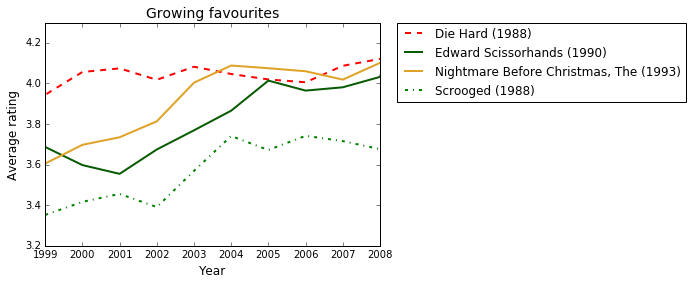

In [323]:
# Plot the Christmas movies rising in popularity

fig = plt.figure(figsize = (720/120, 500/120), dpi = 120)                                                  
ax = fig.add_subplot(1,1,1)

# Add lines
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][6]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][6]],
         color='#FF0000', linestyle='dashed', linewidth=2.0,
         label = df2['Title'][6])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][14]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][14]],
         color='#065A00', linewidth=2.0, 
         label = df2['Title'][14])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][16]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][16]], 
         color='#DFA226', linewidth=2.0,
         label = df2['Title'][16])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][23]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][23]], 
         color='green', linestyle='dashdot', linewidth=2.0, 
         label = df2['Title'][23])

# Add labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average rating', fontsize=12)
plt.title('Growing favourites', fontsize=14)

# Set x-axis
plt.xlim((1999, 2008))
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Set y-axis
plt.ylim((3.2, 4.3))

# Create legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

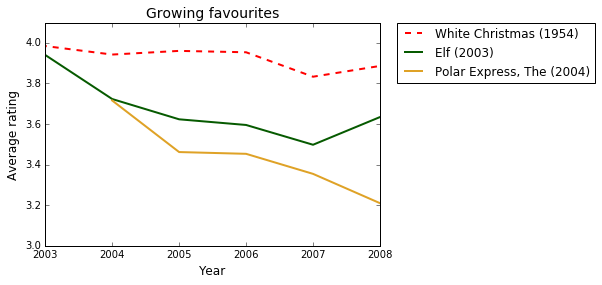

In [325]:
# Plot the Christmas movies rising in popularity

fig = plt.figure(figsize = (720/120, 500/120), dpi = 120)                                                  
ax = fig.add_subplot(1,1,1)

# Add lines
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][12]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][12]],
         color='#FF0000', linestyle='dashed', linewidth=2.0,
         label = df2['Title'][12])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][20]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][20]],
         color='#065A00', linewidth=2.0, 
         label = df2['Title'][20])
plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][27]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][27]], 
         color='#DFA226', linewidth=2.0,
         label = df2['Title'][27])

# Add labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average rating', fontsize=12)
plt.title('Growing favourites', fontsize=14)

# Set x-axis
plt.xlim((2003, 2008))
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Set y-axis
plt.ylim((3.0, 4.1))

# Create legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

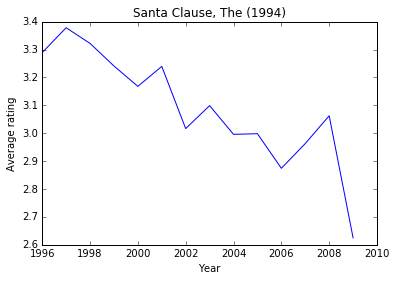

In [313]:
num = 29
year = df3['Year'].loc[df3['Title'] == df2['Title'][num]]
rating = df3['AverageRating'].loc[df3['Title'] == df2['Title'][num]]

plt.plot(df3['Year'].loc[df3['Title'] == df2['Title'][num]], 
         df3['AverageRating'].loc[df3['Title'] == df2['Title'][num]])
plt.xlabel('Year')
plt.ylabel('Average rating')
plt.title(df2['Title'][num])
plt.show()

#plt.show()

# Perennially popular
## A Christmas Story (0)
## It's a Wonderful Life (1)
## Brazil (2) - kind of, there is a drop at the end, consider excluding
## Die Hard (6)
## Love Actually (7)
## Holiday Inn (10)
## Miracle on 34th Street (13)
## Lethal Weapon (15)

# Growing favourites
## Die Hard (6)
## Trading Places (11)
## Edward Scissorhands (14)
## The Nightmare Before Christmas (16)
## Scrooged (23)
## Die Hard 2 (25) - kind of

# Losing popularity
## A Christmas Carol (9)
## White Christmas (12)
## Bad Santa (17)
## Elf (20)
## While You Were Sleeping (22)
## Polar Express (27)
## The Santa Clause (29)

# Consistently mediocre
## Home Alone (31)
## Prancer (33)
## Reindeer Games (34)

In [340]:
df4 = 
df3.groupby('Title').first()['AverageRating'] - df3.groupby('Title').last()['AverageRating'] 

Title
Bad Santa (2003)                                                           0.9547
Batman Returns (1992)                                                      0.2126
Brazil (1985)                                                              0.8037
Charlie Brown Christmas, A (1965)                                          0.1786
Christmas Carol, A (1938)                                                  0.2431
Christmas Story, A (1983)                                                  0.0516
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)     0.5242
Die Hard (1988)                                                           -0.1573
Die Hard 2 (1990)                                                          0.0978
Edward Scissorhands (1990)                                                -0.8846
Elf (2003)                                                                 0.3950
Family Stone, The (2005)                                                  -0.1381
Ghostbuste

In [73]:
## Genres of Christmas movies

query = ("""\
SELECT SUM(movies.action) AS Action, 
      SUM(movies.adventure) AS Adventure, 
      SUM(movies.animation) AS Animation,
      SUM(movies.childrens) AS Childrens, 
      SUM(movies.comedy) AS Comedy, 
      SUM(movies.crime) AS Crime,
      SUM(movies.documentary) AS Documentary, 
      SUM(movies.drama) AS Drama, 
      SUM(movies.fantasy) AS Fantasy,
      SUM(movies.noir) AS Noir, 
      SUM(movies.horror) AS Horror, 
      SUM(movies.musical) AS Musical,
      SUM(movies.mystery) AS Mystery, 
      SUM(movies.romance) AS Romance, 
      SUM(movies.scifi) AS SciFi,
      SUM(movies.thriller) AS Thriller, 
      SUM(movies.war) AS War, 
      SUM(movies.western) AS Western
FROM movies
WHERE movies.title IN (
   SELECT DISTINCT movies.title
   FROM movies
   LEFT JOIN ratingsdata
      ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid));
""")

cursor = cnx.cursor() 
cursor.execute(query)
df4 = DataFrame(cursor.fetchall(), 
               columns = ['Action', 'Adventure', 'Animation',
                          'Childrens', 'Comedy', 'Crime', 
                          'Documentary', 'Drama', 'Fantasy', 
                          'Noir', 'Horror', 'Musical', 'Mystery',
                          'Romance', 'SciFi', 'Thriller', 'War',
                          'Western'])

In [74]:
df4 = df4.transpose()

In [75]:
df4.columns = ['Count']

In [107]:
df4 = df4.sort_values(by = 'Count', ascending = 0)

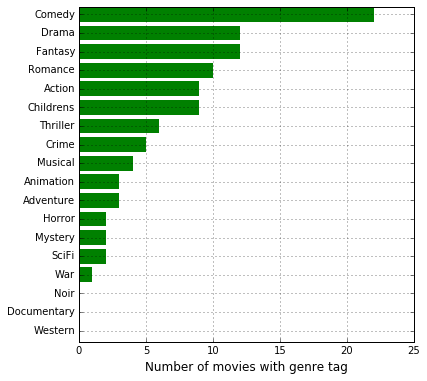

In [116]:
#plt.barh(x, df4['Count'])
#plt.yticks(x + 0.5, df4.index)

x = np.arange(len(df4))

fig = plt.figure(figsize = (720/120, 800/120), dpi = 120)
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, df4['Count'], color = "g",
                   edgecolor='none')
plt.yticks(x + 0.4, df4.index)
plt.gca().invert_yaxis()
plt.xlabel('Number of movies with genre tag', fontsize = 12)
plt.grid(True)

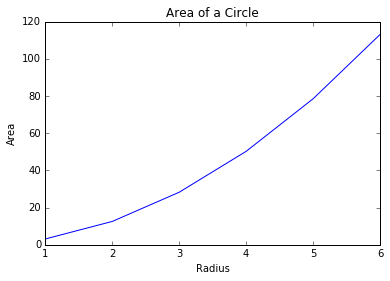

In [140]:
radius = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
area = [3.14159, 12.56636, 28.27431, 50.26544, 78.53975, 113.09724]
plt.plot(radius, area)
plt.xlabel('Radius')
plt.ylabel('Area')
plt.title('Area of a Circle')
plt.show()